# Minimize leading HC $\Delta R_{jj}$

**Goal:** See if modifying our analysis using a different pairing alg (i.e, minimizing $\Delta R_{jj}$ for the leading HC) can help our sensitivity!

I added this functionality to `resolved-recon`, which can be turned on with the `--min_dRjjlead` flag.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import json
import ROOT
from root_numpy import root2array, hist2array
from matplotlib import gridspec

import os
os.sys.path.append('../../hh4b-background-estimation/hep_ml')
from hep_ml import reweight
import pickle

os.sys.path.append('../code')
from plotting import sig_bkg_massplanes, bkg_2bsameHC_massplanes, bkg_2b_rw_massplanes
from plotting import cf_2b_same_HC, cf_1d_dists
from plotting import SR_x,SR_y1,SR_y2,CR_x,CR_y1,CR_y2,SB_x,SB_y1,SB_y2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: Compare the signal and background

I'm again running on EMTopo.

- Running over the SMNR files

`resolved-recon --mc --lumi 24.3 -t triggers-2016.dat -o smnr_topo16_minMDR.root --min_dRjj_lead ../public/hh4b/SMNR/user.saparede.HH4B.450000.SM_HH.MC16a-2015-2016.AB21.2.72-MAY2019_VRFIX.pflow_vr_min-systs-both_MiniNTuple.root/user.saparede.18276059._0000*.MiniNTuple.root`


- Running over the data 16 files

`resolved-recon -o data16_topo16_minMDR.root --min_dRjj_lead --unblind -t triggers-2016.dat ../public/hh4b/data/user.bstanisl.HH4B.period?.data16..AB21.2.72-MAY2019.topo_min_MiniNTuple.root/*.root`


Let's load in the signal and 2b background histograms!

In [3]:
basefileName = "../../hh4b-resolved-reconstruction/{}_topo16_minMDR.root"

In [4]:
smnr_SR = pd.DataFrame(root2array(basefileName.format("smnr"),"sig"))

In [5]:
smnr_SR.mc_sf.sum()

12.429584218179842

Ok, let's look at the $m_{4j}$ in the SR for the signal and the unweighted 2b 2016 data with the appropriate cuts applied, but before the kinematic rescaling.

In [6]:
data16_SR = pd.DataFrame(root2array(basefileName.format("data16"),"sig"))
data16_SB = pd.DataFrame(root2array(basefileName.format("data16"),"sideband"))

As a first order estimate, just multiply the weights by the 4b / 2b normalization factor in the SB.

In [7]:
N = np.sum(data16_SB.ntag >= 4) / np.sum(data16_SB.ntag == 2) 
N

0.005714444935848108

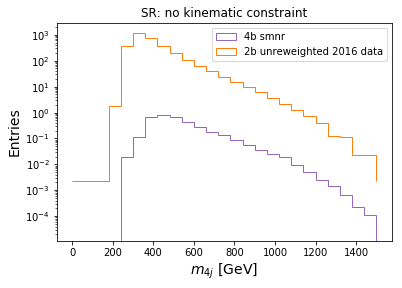

In [8]:
smnr_mask = (smnr_SR.ntag >= 4)
data16_mask = (data16_SR.ntag == 2)

kargs = {'bins':25, 'range':(0,1500), 'histtype':'step', 'log':True}

plt.hist(smnr_SR.loc[smnr_mask,'m_hh'],label='4b smnr',color='C4',
         weights=smnr_SR.loc[smnr_mask,'mc_sf'],**kargs)

plt.hist(data16_SR.loc[data16_mask,'m_hh'],label='2b unreweighted 2016 data',color='C1',
         weights=N*data16_SR.loc[data16_mask,'mc_sf'],**kargs)

plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
plt.ylabel('Entries',fontsize=14)
plt.legend()
plt.title('SR: no kinematic constraint')

plt.savefig('figures/orig_2b/m_hh.pdf',bbox_inches='tight')

plt.show()

I'm not sure if this is right or not...

In [9]:
np.min(smnr_SR.pT_4)

40.00020980834961

### Mass plane check

Since I'm now revising the nano Ntuples using the lessons that I've gleaned from my framework, I think it's a good idea to sanity check that what I saw before at an earlier snapshot of the anlaysis still hold at the end, and in this new frame work!

In [10]:
smnr   = pd.DataFrame(root2array(basefileName.format("smnr"),  "fullmassplane"))
data16 = pd.DataFrame(root2array(basefileName.format("data16"),"fullmassplane"))

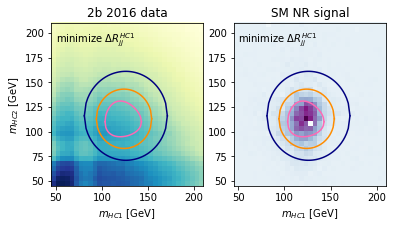

In [11]:
text = "minimize $\Delta R_{jj}^{HC1}$"
sig_bkg_massplanes(data16, smnr, text=text,figDir='figures/min_dRjj_h1/orig_2b')

Ok, I was *encouraged* that the distribution was no longer peaking in the SR, but we're also very concerned about what's up with these stripes, so also something that we're planning on following up on.

In [12]:
cb = 16
mhi=[(50,210)]*2

myloc=(55,190)
sig_bkg_massplanes(data16, smnr, cb, mhi, myloc, text=text,
                   figDir='figures/min_dRjj_h1/orig_2b',tag="sig_2b2016_coarserBins")

### Look at the reweighting variables in the SB before applying the reweighting

For a solution that I can iterate on, I'm just going to look at the same reweighting variables that were used for the splines.

- njets: number of jets with $p_T$ > 40 GeV and $|\eta| < 2.5$
- pT_4: The $p_T$ of the lowest $p_T$ analysis jet
- pT_2: The $p_T$ of the subleading analysis jet
- eta_i: The average $|\eta|$ for all the jets
- dRjj_1: The opening angle between the closest two jets
- dRjj_2: The opening angle between the other two jets


In [13]:
data16_SB.head()

run_number  event_number  mc_sf  ntag  njets  nValidPairs  \
0      303846    3241167092    1.0     2      4            1   
1      303846    3240065999    1.0     2      4            1   
2      303846    3241007529    1.0     2      5            1   
3      303846    3238675994    1.0     2      4            1   
4      303846    3240143440    1.0     2      4            1   

   kinematic_region        m_hh      pt_hh      X_wt    ...       pT_h2_j2  \
0                 2  580.923385  65.588156  6.019627    ...      63.367577   
1                 2  461.723399  35.321210  4.184132    ...      53.353130   
2                 2  416.797622  40.814995  1.031009    ...     146.195755   
3                 2  456.957316  48.278984  7.043485    ...      97.037437   
4                 2  328.131665  15.123059  5.130725    ...      59.864609   

   eta_h2_j2  phi_h2_j2  tag_h2_j2  angle_h2_j2       pT_4        pT_2  \
0   0.338658  -3.139296       True     2.243401  63.367577  144.503372   
1  -1.048258   2.261035      False     1.728351  50.657612   91.231789   
2  -0.425786  -2.562846       True     0.658033  40.465542  108.204788   
3   0.303221   2.272273      False     1.248193  46.154472   99.428078   
4   0.727872  -3.083161      False     1.736871  42.463684   81.067873   

      eta_i    dRjj_1    dRjj_2  
0  1.005742  0.767702  1.381089  
1  0.861546  1.556395  3.270898  
2  0.344716  1.190398  2.178964  
3  0.792222  1.538437  1.564828  
4  0.596125  0.810108  2.522788  

[5 rows x 56 columns]

Also, I'm not applying the $X_{wt}$ cut here, since it isn't getting applied in the 2b -> 4b reweighting.

I'm normalizing the histograms in the plots below, since this is what is needed for distribuiton estimation as inputs to the BDTs.

In [13]:
cols = ['njets', 'm_hh','pt_hh','X_wt','m_hh_cor',
        'm_h1','E_h1','pT_h1','eta_h1','phi_h1','dRjj_h1',
        'm_h2','E_h2','pT_h2','eta_h2','phi_h2','dRjj_h2',
        'm_h1_j1','E_h1_j1','pT_h1_j1','eta_h1_j1','phi_h1_j1','tag_h1_j1',
        'm_h1_j2','E_h1_j2','pT_h1_j2','eta_h1_j2','phi_h1_j2','tag_h1_j2',
        'm_h2_j1','E_h2_j1','pT_h2_j1','eta_h2_j1','phi_h2_j1','tag_h2_j1',
        'm_h2_j2','E_h2_j2','pT_h2_j2','eta_h2_j2','phi_h2_j2','tag_h2_j2',
        'pT_4','pT_2','eta_i','dRjj_1','dRjj_2']

nBins = [7,50,50,50,50,
         50,50,50,50,50,50,
         50,50,50,50,50,50,
         50,50,50,50,50,2,
         50,50,50,50,50,2,
         50,50,50,50,50,2,
         50,50,50,50,50,2,
         50,50,50,50,50,2,
         50,50,50,50,50]
        
myRanges = [(3.5,10.5),(0,600),(0,150),(0,8),(0,1200),
            (40,180),(0,1000),(0,400),(-2.5,2.5),(-np.pi,np.pi),
            (40,180),(0,1000),(0,400),(-2.5,2.5),(-np.pi,np.pi),
            (0,40),(0,500),(0,250),(-2.5,2.5),(-np.pi,np.pi),(-0.5,1.5),
            (0,40),(0,500),(0,250),(-2.5,2.5),(-np.pi,np.pi),(-0.5,1.5),
            (0,40),(0,500),(0,250),(-2.5,2.5),(-np.pi,np.pi),(-0.5,1.5),
            (0,40),(0,500),(0,250),(-2.5,2.5),(-np.pi,np.pi),(-0.5,1.5),
            (0,125),(0,200),(0,2.5),(0,np.pi),(0,np.pi)]


/cvmfs/sft.cern.ch/lcg/views/LCG_94python3/x86_64-slc6-gcc8-opt/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/cvmfs/sft.cern.ch/lcg/views/LCG_94python3/x86_64-slc6-gcc8-opt/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


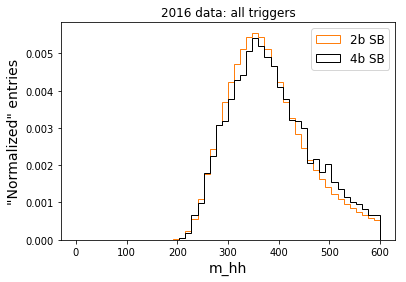

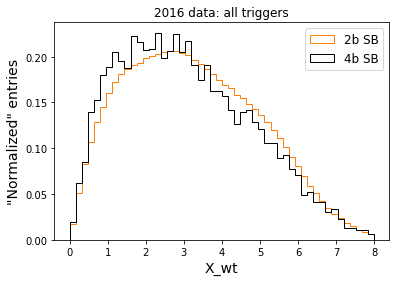

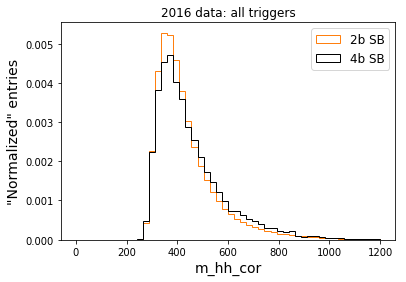

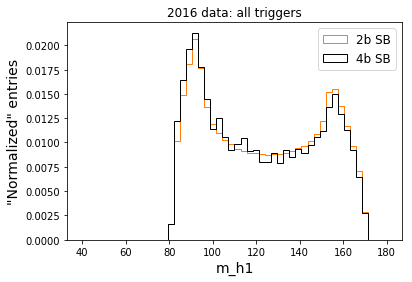

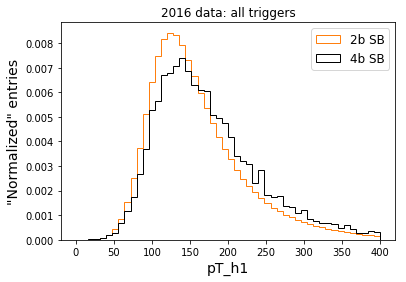

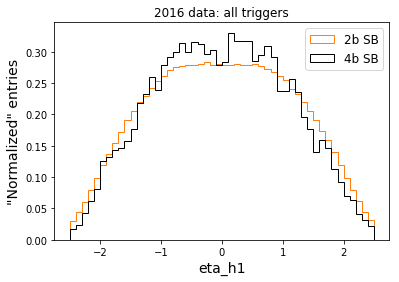

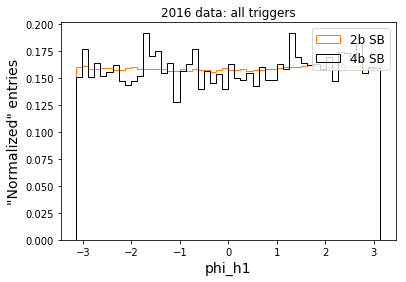

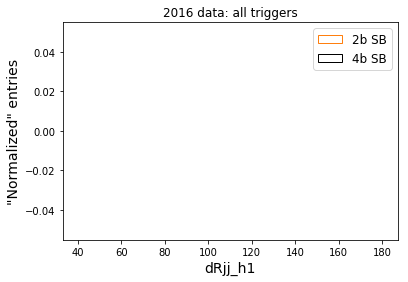

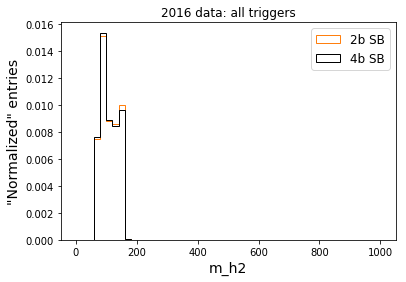

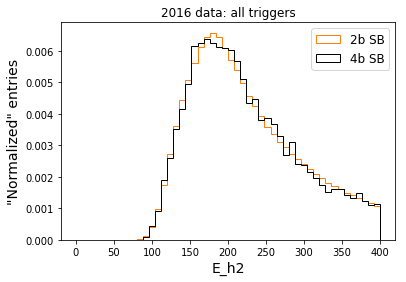

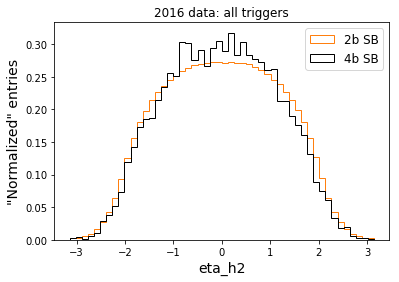

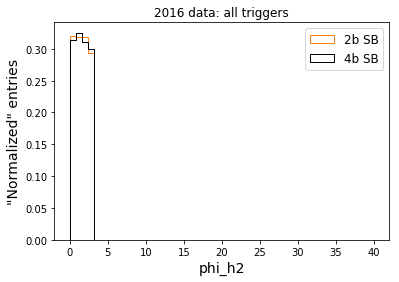

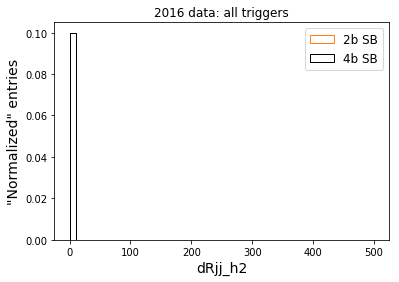

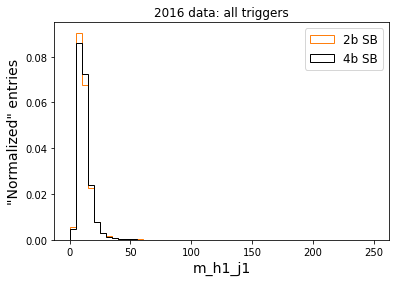

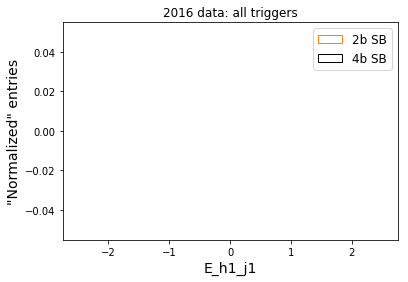

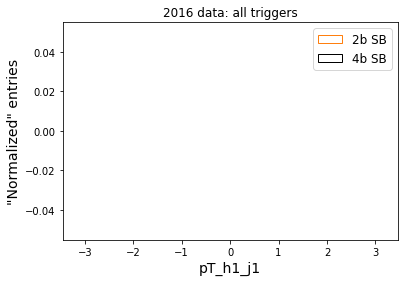

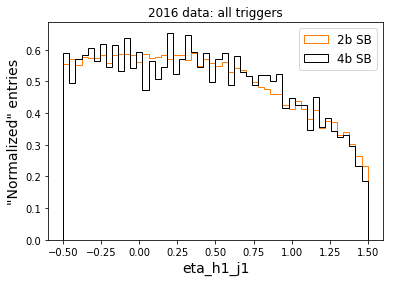

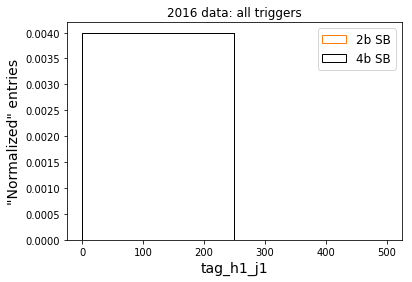

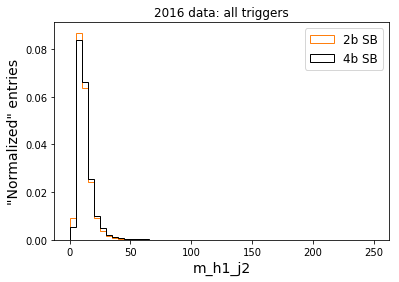

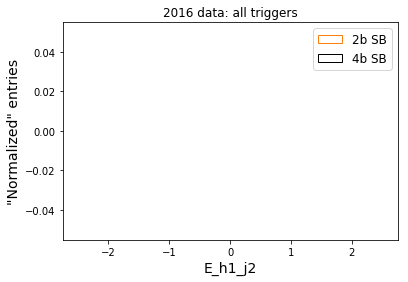

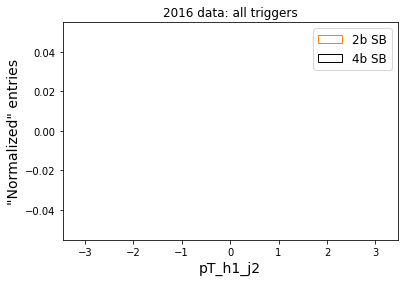

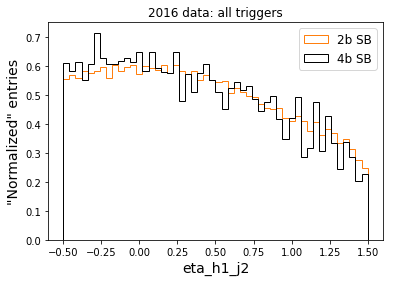

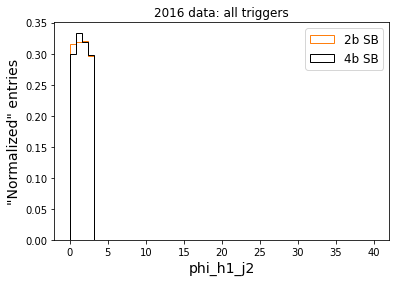

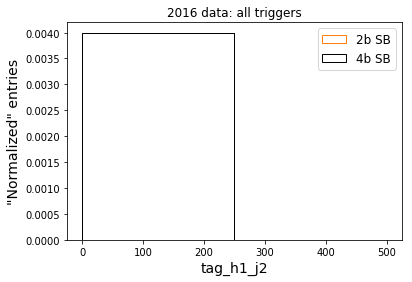

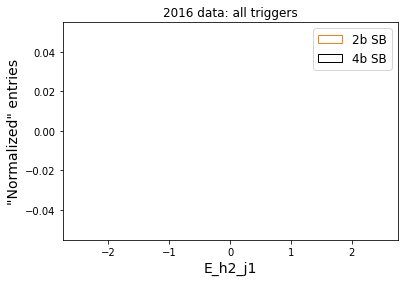

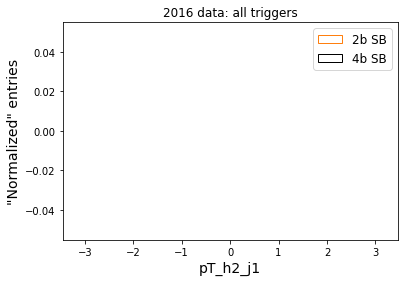

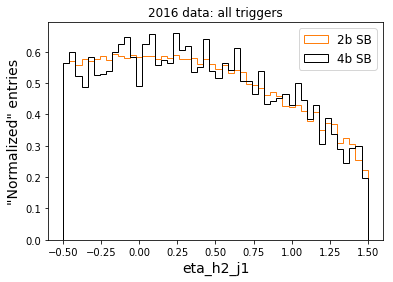

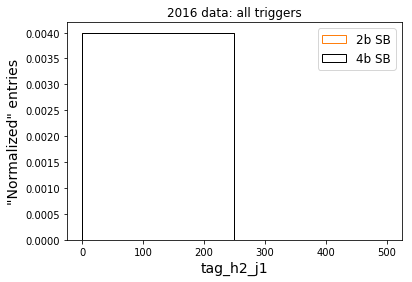

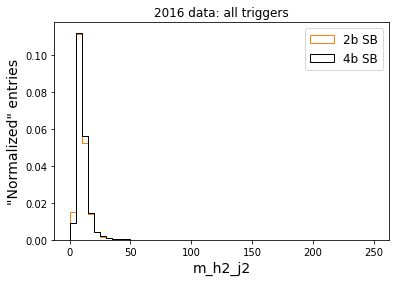

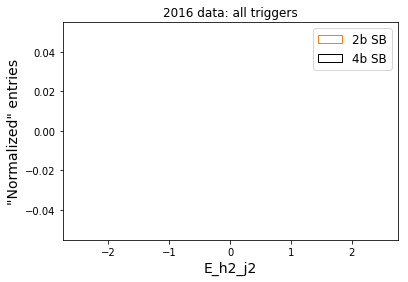

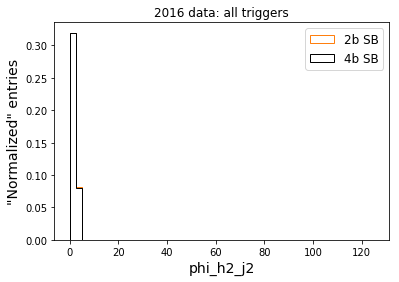

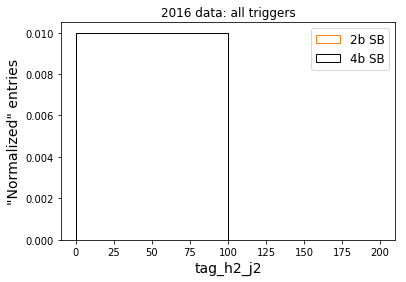

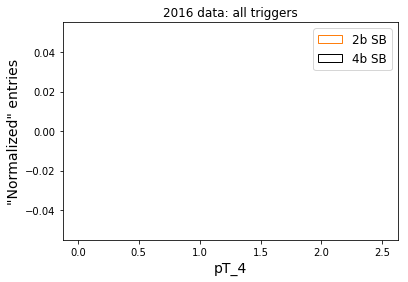

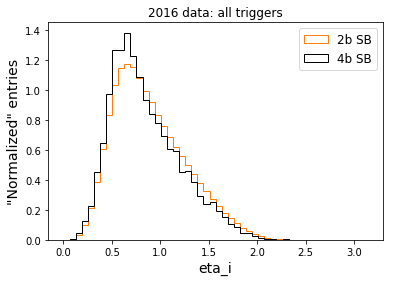

In [14]:
mask_2b = (data16_SB.ntag == 2)
mask_4b = (data16_SB.ntag >= 4)

for c, nb, myRange in zip(cols,nBins,myRanges):
    
    kargs = {'histtype':'step','density':True,
             'bins':nb,'range':myRange}
    
    plt.figure()
    plt.hist(data16_SB.loc[mask_2b,c],color='C1',label='2b SB',**kargs)
    plt.hist(data16_SB.loc[mask_4b,c],color='k',label='4b SB',**kargs)
    
    plt.xlabel(c,fontsize=14)
    plt.ylabel('"Normalized" entries',fontsize=14)
    plt.legend(fontsize=12)
    plt.title('2016 data: all triggers')
    
    plt.savefig('figures/min_dRjj_h1/orig_2b/{}.pdf'.format(c),bbox_inches='tight')
    

Ok, most of the distributions look not that bad, with the exception of the # of jets.

Also, the pairing is preferentially splitting the bs between HCs, but I think this is at least understandable.

### Recheck the 2b kinematics modelling the 4b data

Since it's a new pairing algorithm, I think it's worthwhile redoing these $2b \rightarrow 4b$ background modelling checks as well.

In [15]:
HC1_2b = data16.tag_h1_j1 & data16.tag_h1_j2
HC2_2b = data16.tag_h2_j1 & data16.tag_h2_j2

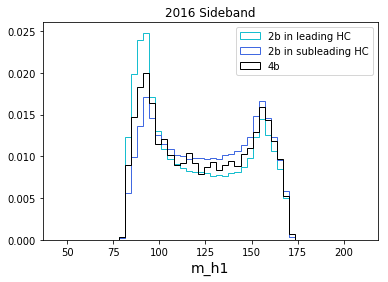

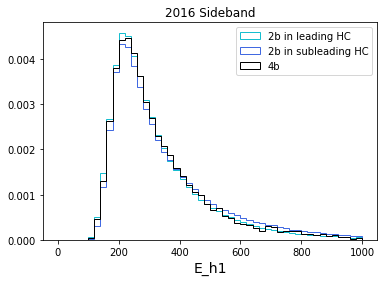

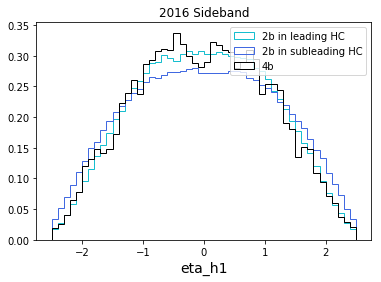

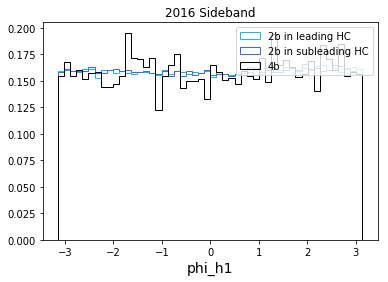

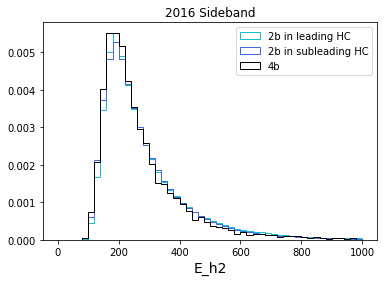

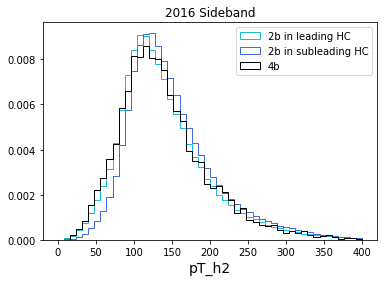

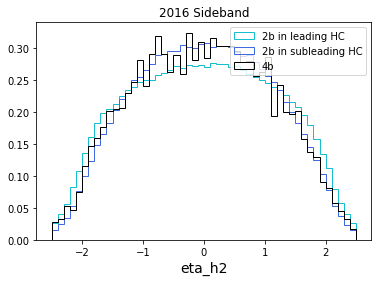

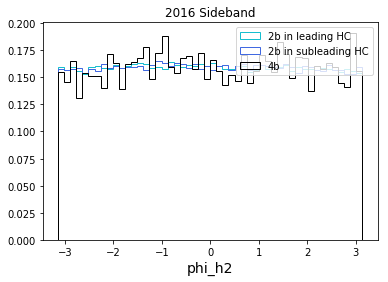

In [22]:
# SB
for c,r in zip(['m_h1','E_h1','pT_h1','eta_h1','phi_h1','m_h2','E_h2','pT_h2','eta_h2','phi_h2'],
               [(45,210),(0,1000),(0,400),(-2.5,2.5),(-np.pi,np.pi)]*2):
    
    plt.figure()
    
    plt.hist(data16.loc[(data16.ntag == 2) & HC1_2b & (data16.kinematic_region == 2),c], 50, r,
             color='C9', histtype='step', label='2b in leading HC', density=True)
    
    plt.hist(data16.loc[(data16.ntag == 2) & HC2_2b & (data16.kinematic_region == 2),c], 50, r,
             color='royalblue', histtype='step', label='2b in subleading HC', density=True)
    
    plt.hist(data16.loc[(data16.ntag >= 4) & (data16.kinematic_region == 2),c], 50, r,
             color='black', histtype='step', label='4b', density=True)
    
    plt.title('2016 Sideband')
    plt.xlabel(c,fontsize=14)
    plt.legend()
    plt.savefig('figures/min_dRjj_h1/HC2b_data16/scalarSum/{}_SB.pdf'.format(c),bbox_inches='tight')
    
    plt.show()

This isn't that good here either, but good that I checked. Maybe I should look at the massplane again?

In [17]:
bkg_2bsameHC_massplanes(data16, figDir='',tag='2016')

Ok, the bins here look ok to me, but maybe Michael would like me to make them coarser again?

In [ ]:
from scipy.stats import entropy
#JS = 0.5 * (entropy(p[1],m) + entropy(p[0],m))

In [ ]:
data16

In [19]:
bkg_2bsameHC_massplanes(data16, cb, mhi,
                        #loc=(50,190), text='', 
                        figDir='',tag='2016')

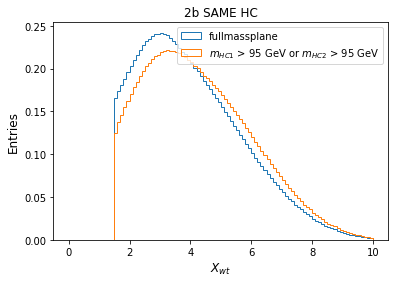

In [56]:
plt.hist(data16.loc[(data16.ntag == 2) & (HC1_2b | HC2_2b),'X_wt'],100,(0,10),density=True,
         histtype='step',label='fullmassplane')
plt.hist(data16.loc[(data16.ntag == 2) & (HC1_2b | HC2_2b) & ((data16.m_h1 > 95) | (data16.m_h2 > 95)),'X_wt'],
         100,(0,10),density=True,
         histtype='step',label='$m_{HC1}$ > 95 GeV or $m_{HC2}$ > 95 GeV')
plt.xlabel('$X_{wt}$',fontsize=12)
plt.ylabel('Entries',fontsize=12)
plt.legend()
plt.title('2b SAME HC')
plt.savefig('figures/min_dRjj_h1/HC2b_data16/X_wt_mHC1_2>95GeV.pdf')
plt.show()

Ok, so it seems like this is *not* likely to be $t\bar{t}$... I wonder what else it could be?

**Question:** How often do we get the same answer for the scalar sum of the constitents vs the HC $p_T$ in terms of the leading vs subleading definitions?

In [20]:
np.sum((data16_SB.pT_h1 - data16_SB.pT_h2) > 0) / len(data16_SB.index)

0.784909126619406

What would these distributions for the SB look like if instead I compared the leading and subleading by HC $p_T$?

../code/plotting.py:305: RuntimeWarning: invalid value encountered in true_divide
  fmt='.',color='orange')
../code/plotting.py:307: RuntimeWarning: invalid value encountered in true_divide
  fmt='.',color='royalblue')


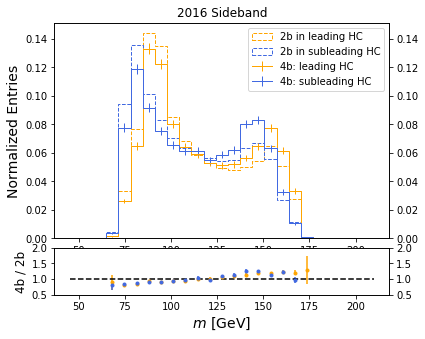

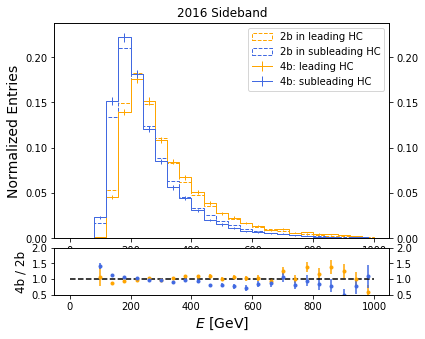

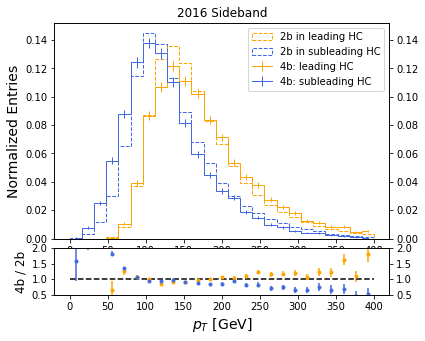

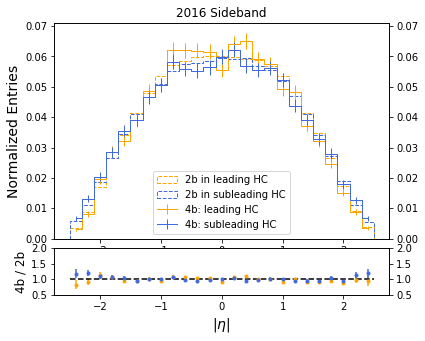

In [50]:
cf_2b_same_HC(data16_SB, nbi=25, title='2016 Sideband', 
              figDir='figures/min_dRjj_h1/HC2b_data16') 

What if I just did an n-jets reweighting, would the 2b HC distributions match up?  Possibly worth a check... but I kind of doubt it.

Interesting... it doesn't even look like this was necessary? Maybe I should check the $n_{jets}$ distribution for this 2b in same HC sample?

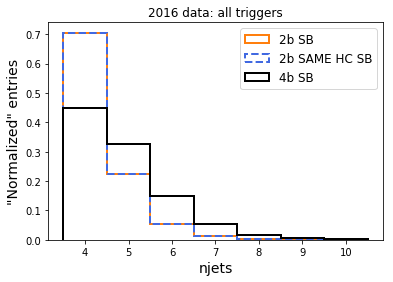

In [57]:
kargs = {'histtype':'step','density':True, 'linewidth':2,
         'bins':7,'range':(3.5,10.5)}
    
plt.figure()
c = cols[0]
n1,_,_ = plt.hist(data16_SB.loc[data16_SB.ntag==2,c],color='C1',label='2b SB',**kargs)
n2,_,_ = plt.hist(data16_SB.loc[(data16_SB.ntag==2) & (HC1_2b | HC2_2b),c], linestyle='--',
         color='royalblue',label='2b SAME HC SB',**kargs)
plt.hist(data16_SB.loc[data16_SB.ntag >= 4,c],color='k',label='4b SB',**kargs)

plt.xlabel(c,fontsize=14)
plt.ylabel('"Normalized" entries',fontsize=14)
plt.legend(fontsize=12)
plt.title('2016 data: all triggers')

plt.savefig('figures/min_dRjj_h1/HC2b_data16/{}_SB.pdf'.format(c),bbox_inches='tight')

plt.show()

In [23]:
n1

array([7.04711523e-01, 2.24964532e-01, 5.47435670e-02, 1.22496868e-02,
       2.65364428e-03, 5.58474736e-04, 1.18572131e-04])

In [24]:
n2

array([7.05072773e-01, 2.24783816e-01, 5.45769337e-02, 1.22524991e-02,
       2.62688218e-03, 5.67691444e-04, 1.19403735e-04])

Ok, it's not a type-O, the histograms are actually different, it just seems that it wasn't visible on this plot. Good to know, and interesting to note (I guess).

I'm not sure what that means in terms of fixing the jet multiplicity between the 2b and 4b samples? I guess this means that fixing the HC distributions for the non-b-tagged HC also will fix the jet multiplicity and other event level variable distributions??

It sounds like more follow-up studies to do!

**Michael's idea:** How would the 2b same HC -> 4b comparison plots look if we looked in bins of the number of jets?

../code/plotting.py:305: RuntimeWarning: invalid value encountered in true_divide
  fmt='.',color='orange')
../code/plotting.py:307: RuntimeWarning: invalid value encountered in true_divide
  fmt='.',color='royalblue')


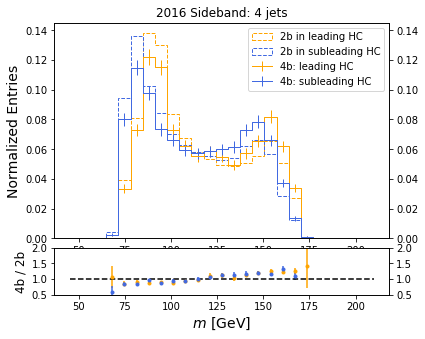

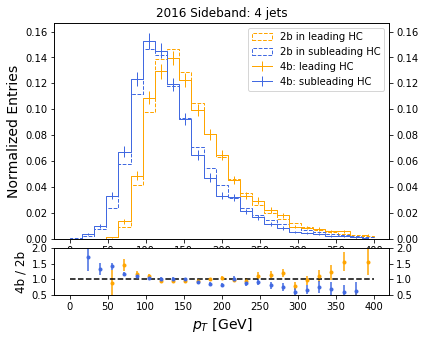

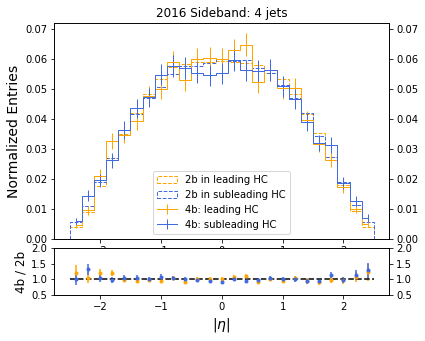

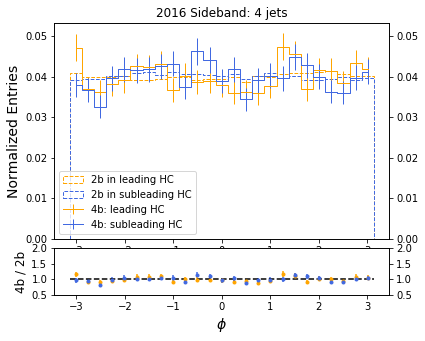

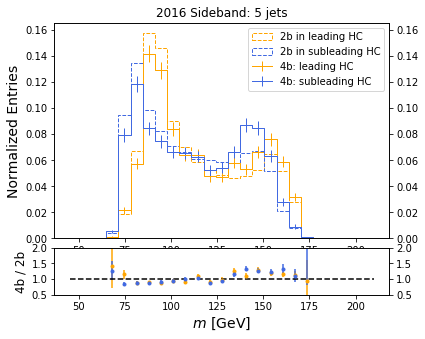

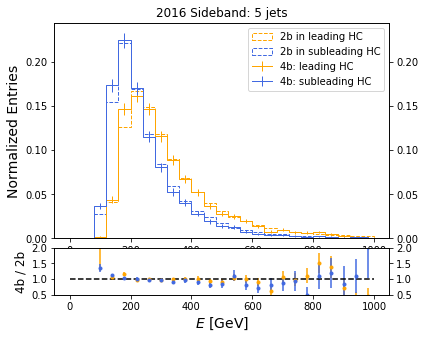

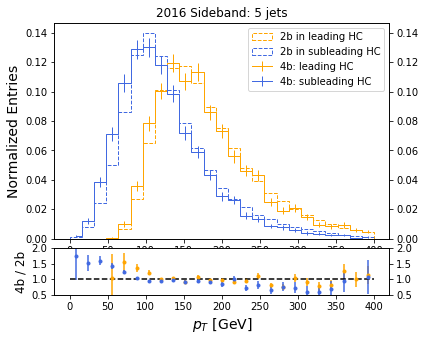

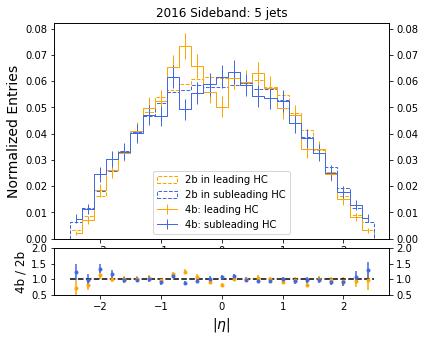

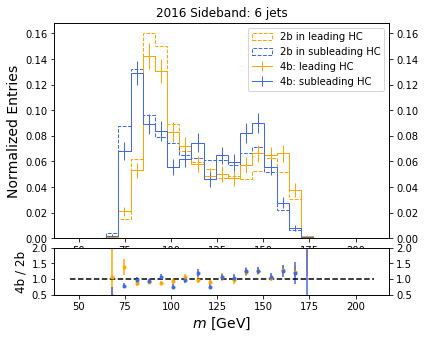

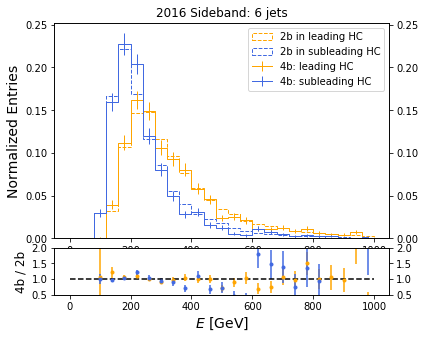

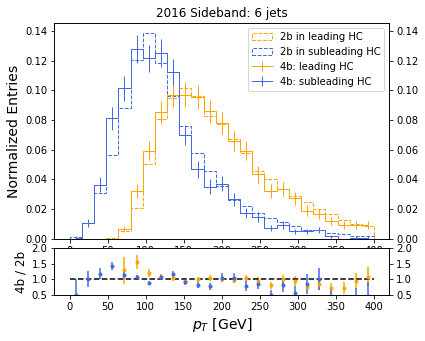

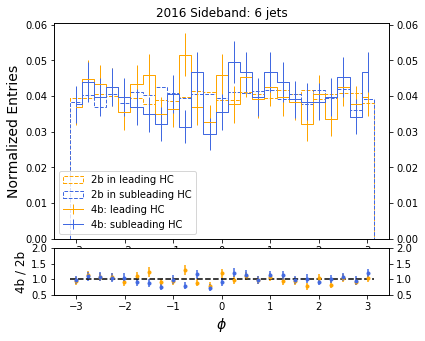

In [58]:
for njets in [4,5,6]:

    cf_2b_same_HC(data16_SB, nbi=nbi, mask=(data16_SB.njets == njets), 
                  title='2016 Sideband: {} jets'.format(njets), 
                  figDir='figures/min_dRjj_h1/HC2b_data16', 
                  tag='SB_{}jets'.format(njets)) 

## Step 2: Re-run Sean's BDT reweighting for the new background definition

**Q:** If I use the 2016 triggers, do I get the same result that I would have gotten just from using the run number?

In [73]:
np.min(data16_SB.run_number),np.max(data16_SB.run_number)

(297730, 311481)

Yes! This is within the checks for the run_number to divide up the years that are given in Sean's BDT_RW.py code.

### Train the BDT

It seemed easier to just train and save the BDT in this notebook and worry about whether to add functionality later when I've discovered whether or not it works!

In [30]:
trainBDT = False

BDT_fname = "myBDTs/BDT_d24_16_rel21_min_dRjj_h1.p"
rw_cols = ['pT_4', 'pT_2', 'eta_i', 'dRjj_1', 'dRjj_2', 'njets']

In [31]:
if trainBDT:

    BDT_params = {
        'n_estimators' : 50,
        'learning_rate' : 0.1,
        'max_depth' : 3,
        'min_samples_leaf' : 125,
        'gb_args' : {'subsample': 0.4}
    }


    reweighter = reweight.GBReweighter(n_estimators=BDT_params['n_estimators'], 
                                       learning_rate=BDT_params['learning_rate'], 
                                       max_depth=BDT_params['max_depth'],
                                       min_samples_leaf=BDT_params['min_samples_leaf'],
                                       gb_args=BDT_params['gb_args'])

    original = data16_SB.loc[data16_SB.ntag == 2,rw_cols]
    target = data16_SB.loc[data16_SB.ntag >= 4,rw_cols]
     
    print("Training on columns:", rw_cols)
    reweighter.fit(original, target)

    pickle.dump(reweighter, open( BDT_fname, "wb" ))
    
else:

    reweighter = pickle.load(open( BDT_fname, "rb" ))


In [33]:
data16['w_2b']    = reweighter.predict_weights(data16[rw_cols])
data16_SR['w_2b'] = reweighter.predict_weights(data16_SR[rw_cols])
data16_SB['w_2b'] = reweighter.predict_weights(data16_SB[rw_cols])

## Step 3: Check the performance w/r.t. the other variables *not* used in the reweighting

../code/plotting.py:488: RuntimeWarning: invalid value encountered in true_divide
  


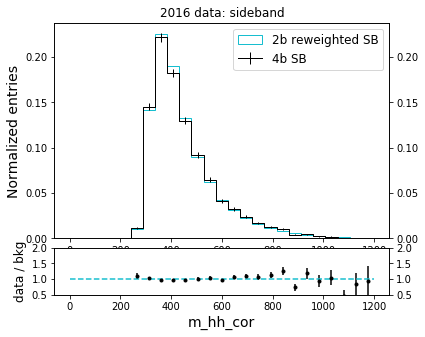

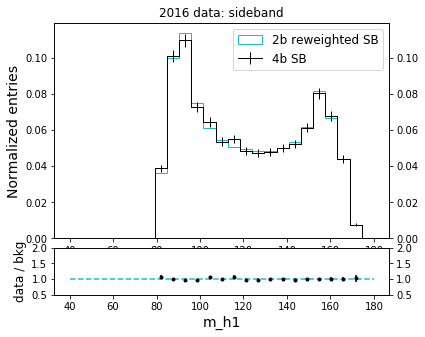

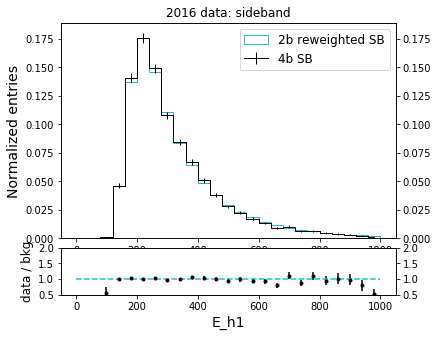

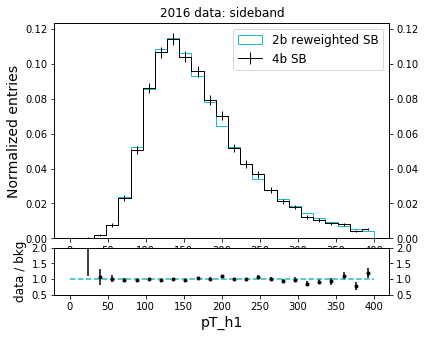

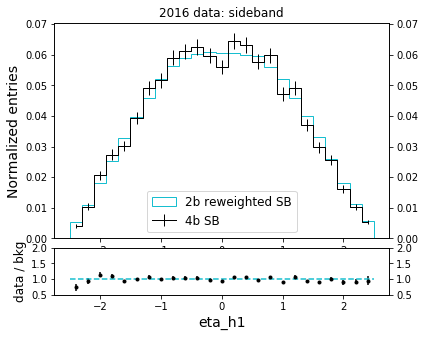

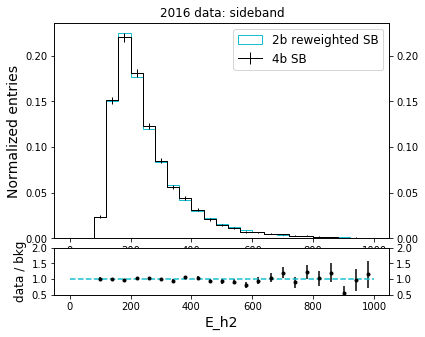

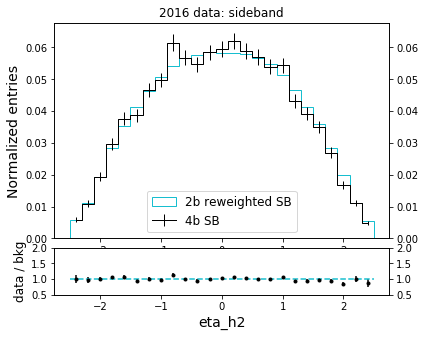

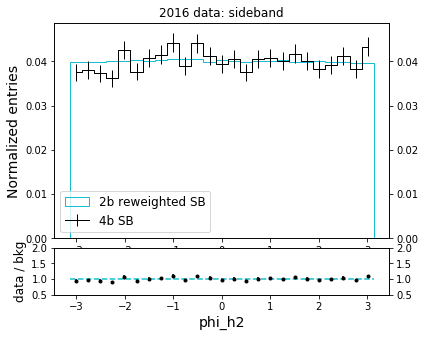

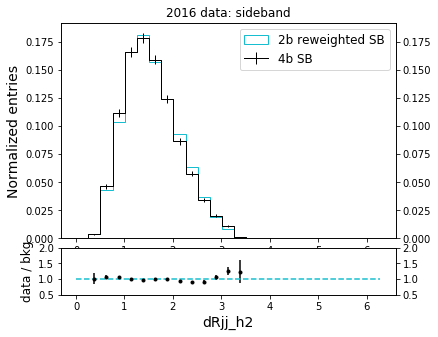

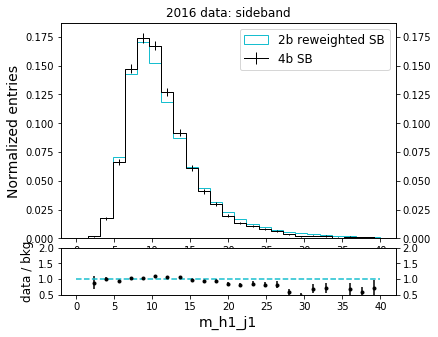

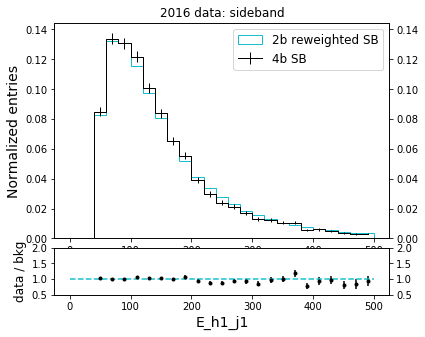

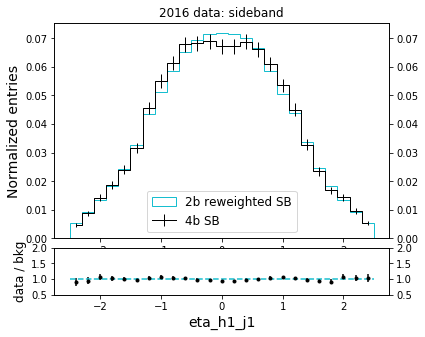

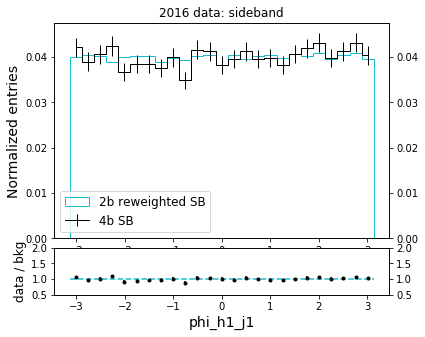

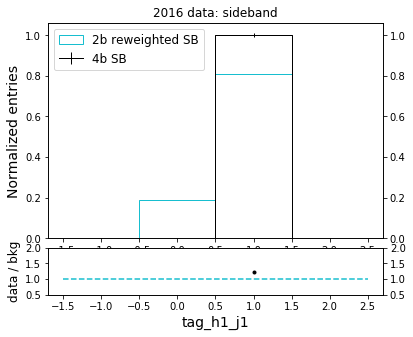

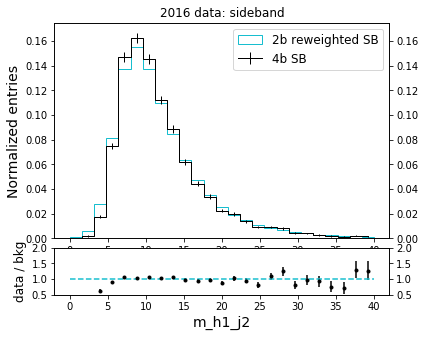

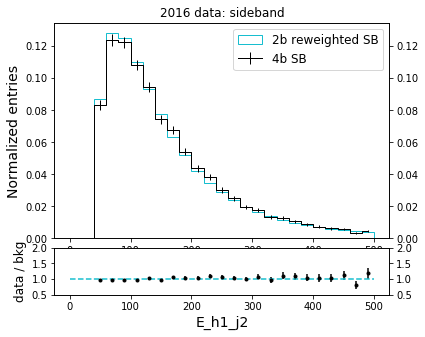

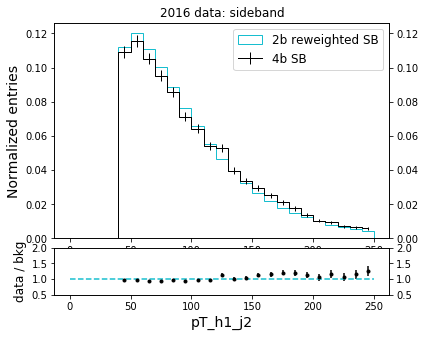

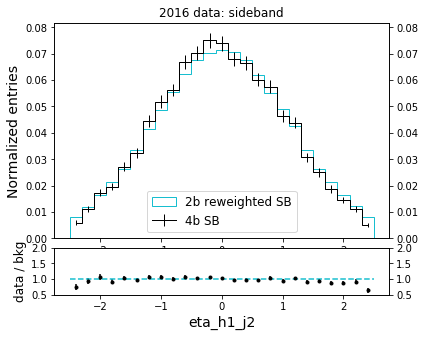

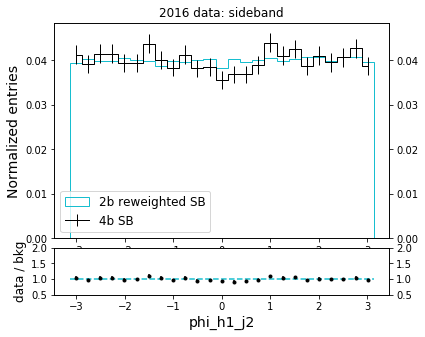

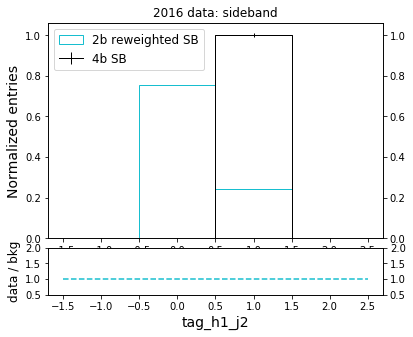

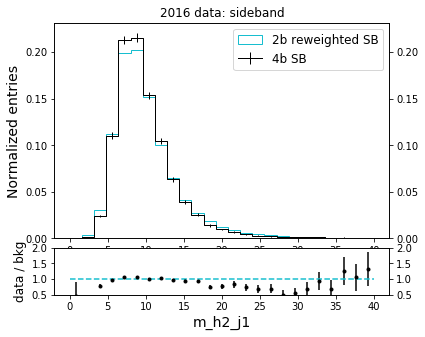

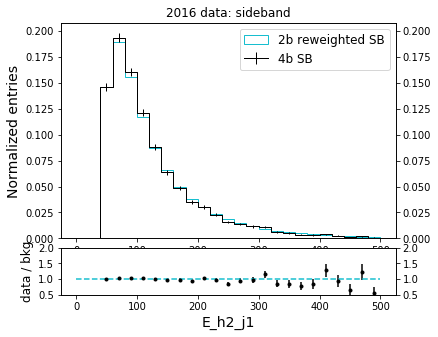

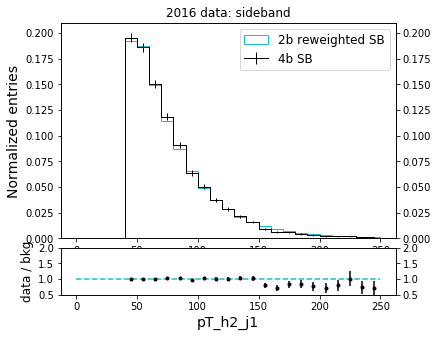

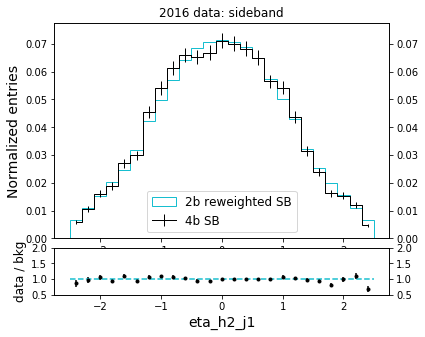

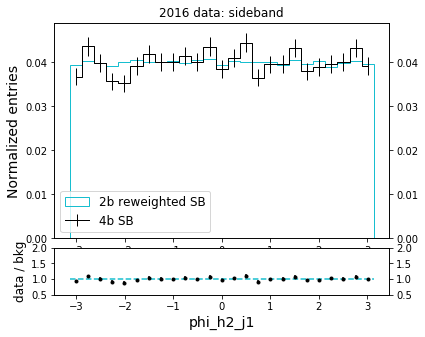

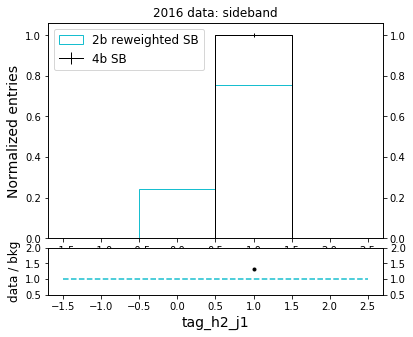

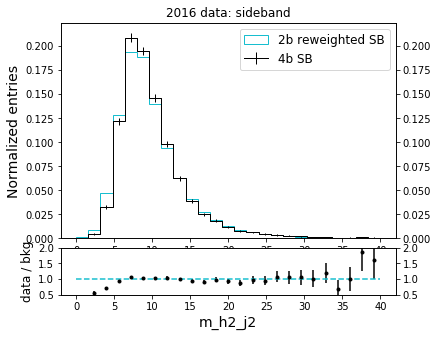

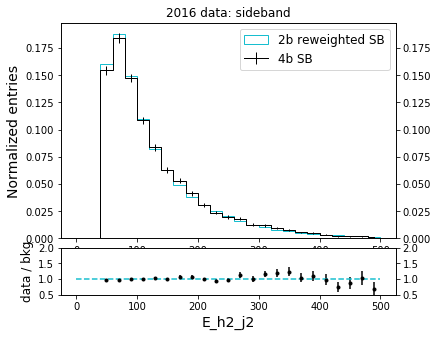

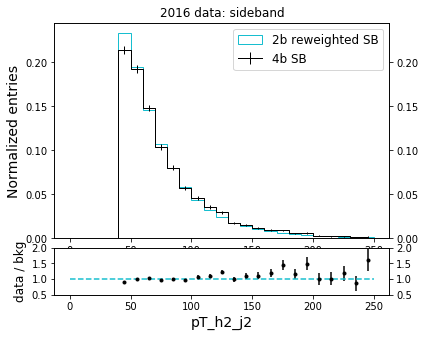

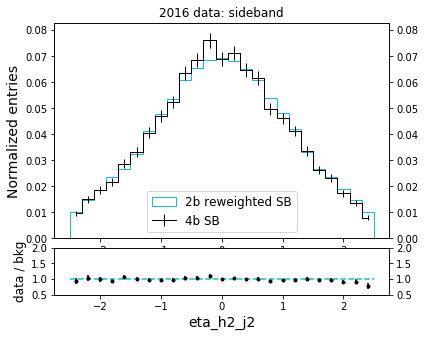

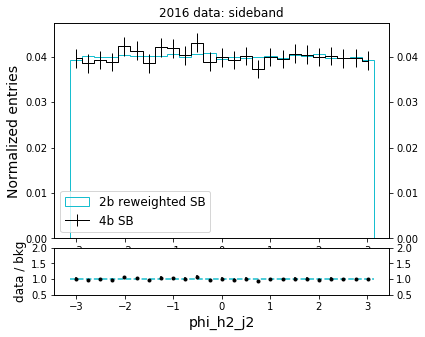

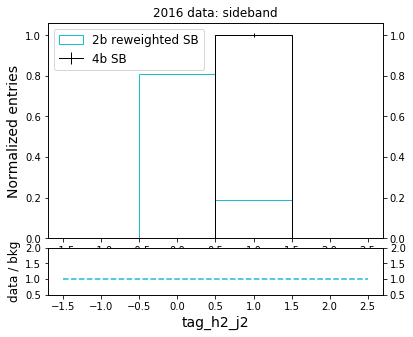

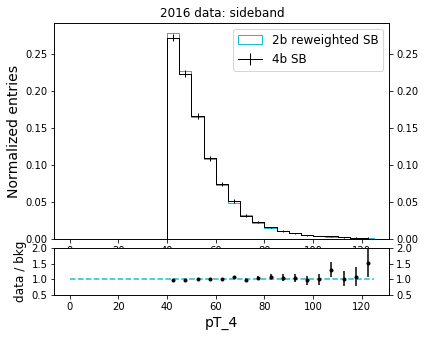

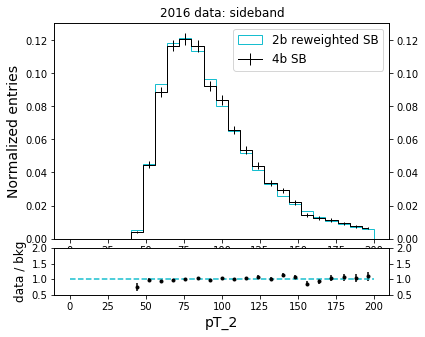

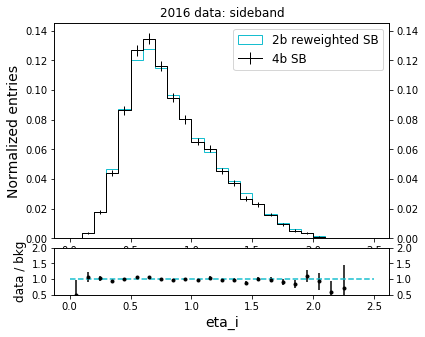

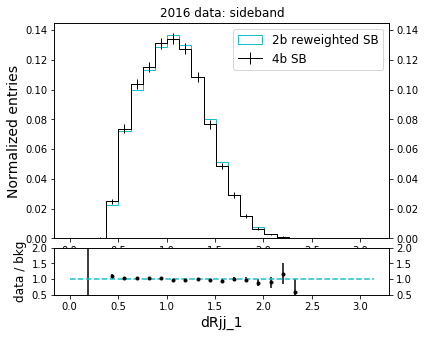

In [38]:
cf_1d_dists(data16_SB,drawUnweighted=False,nbi=25,
            figDir='figures/min_dRjj_h1/rw_2b/',tag='_SB')

../code/plotting.py:488: RuntimeWarning: invalid value encountered in true_divide
  


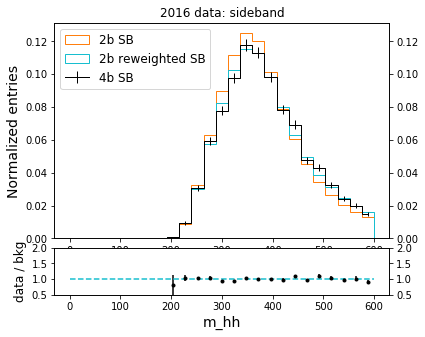

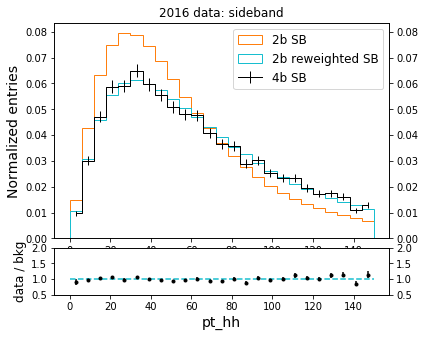

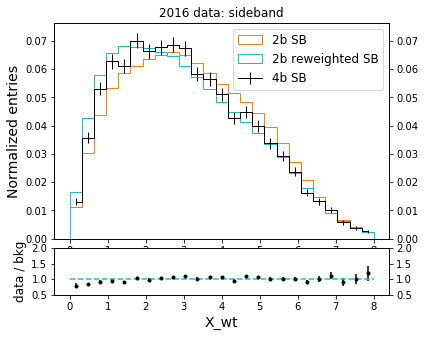

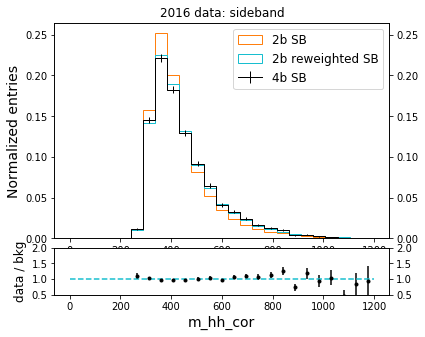

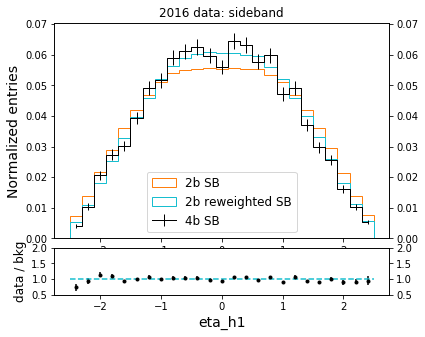

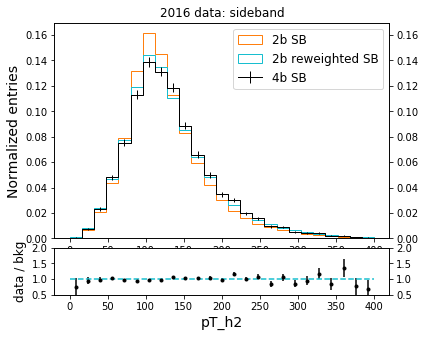

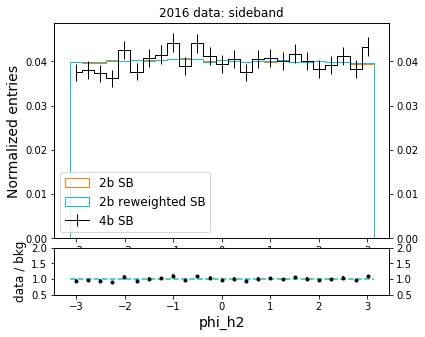

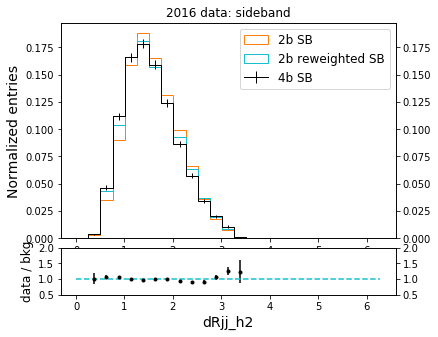

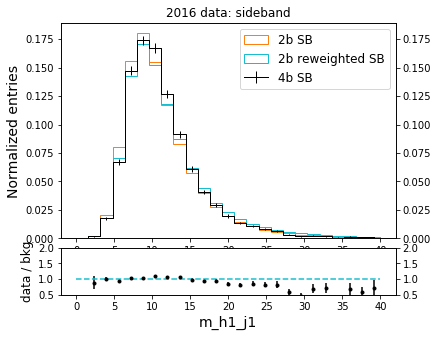

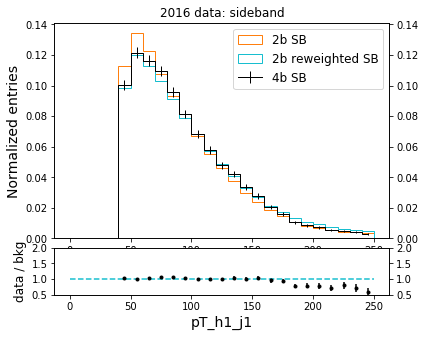

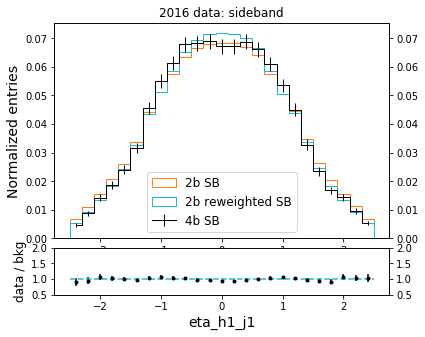

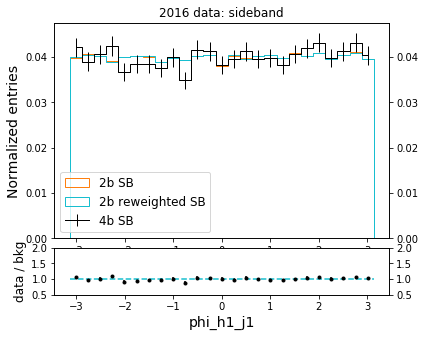

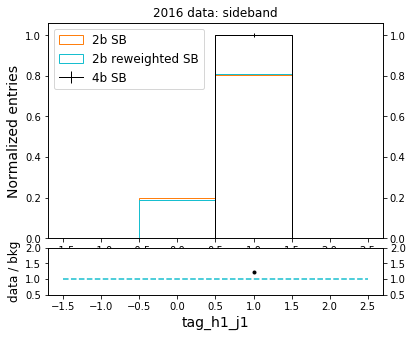

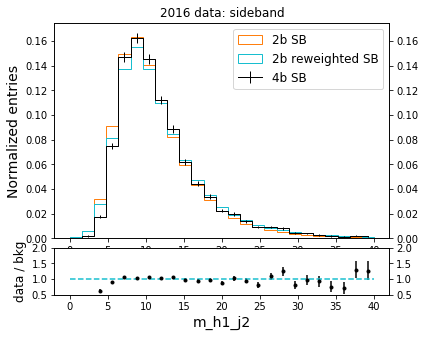

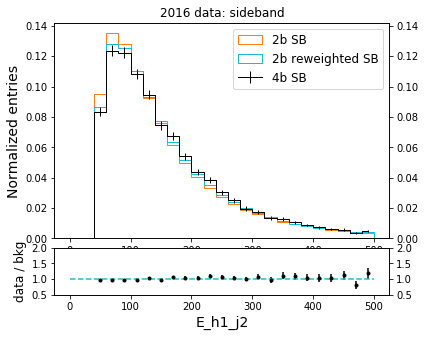

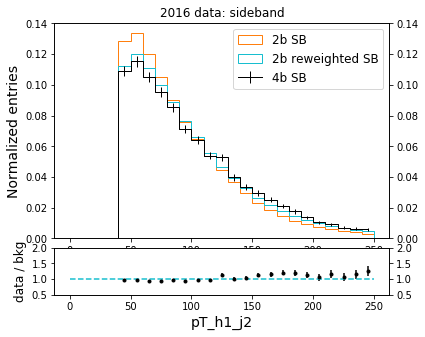

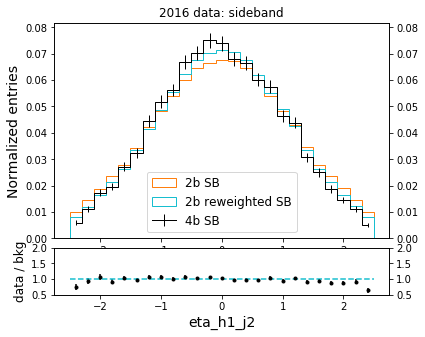

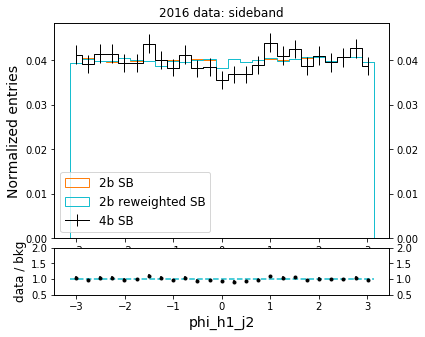

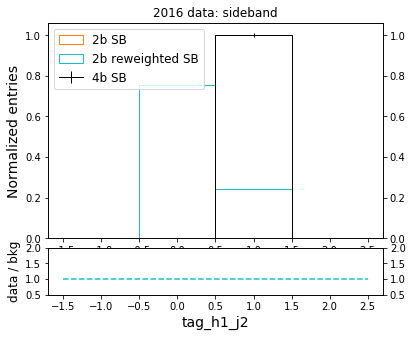

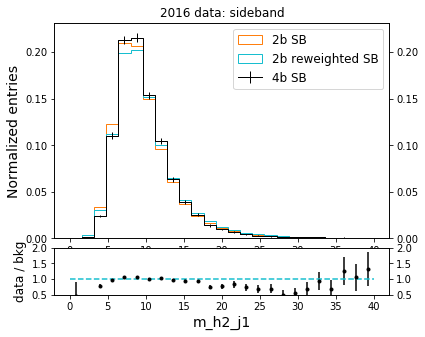

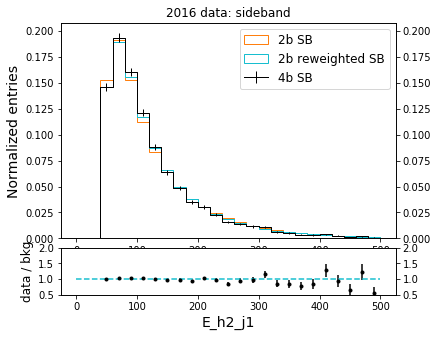

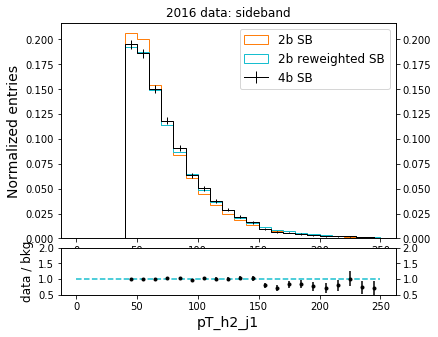

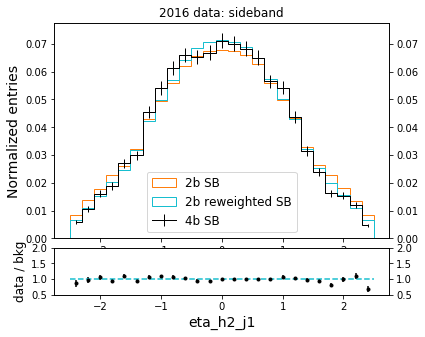

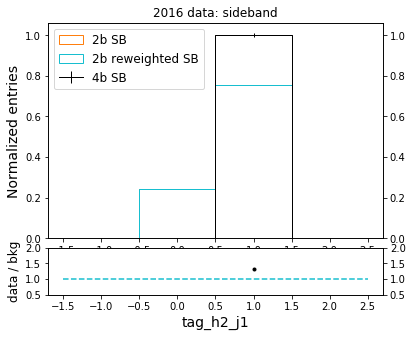

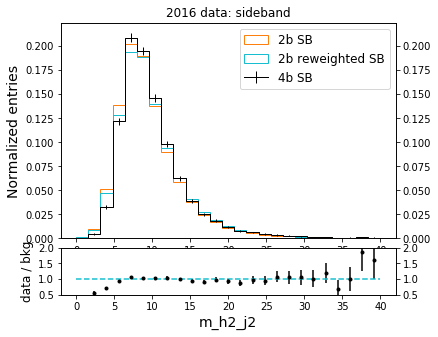

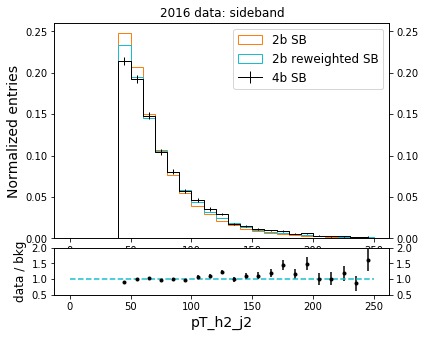

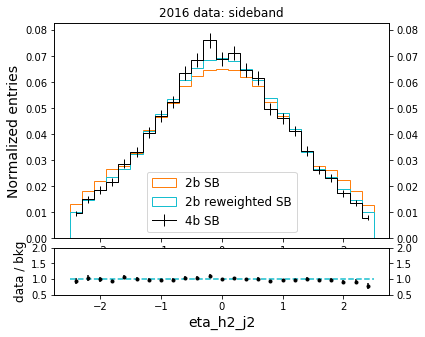

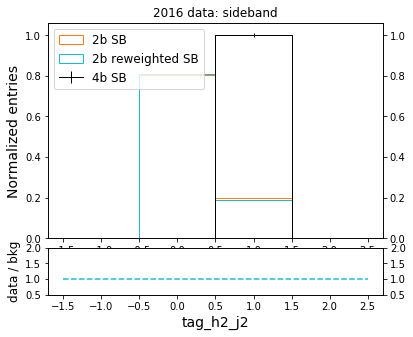

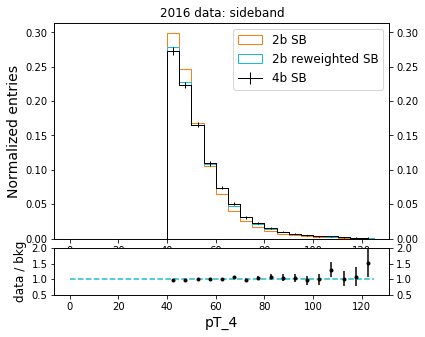

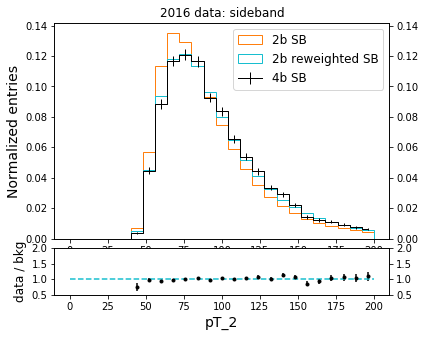

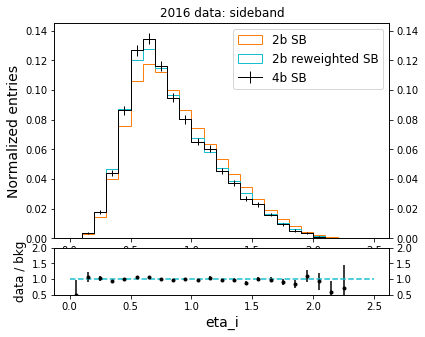

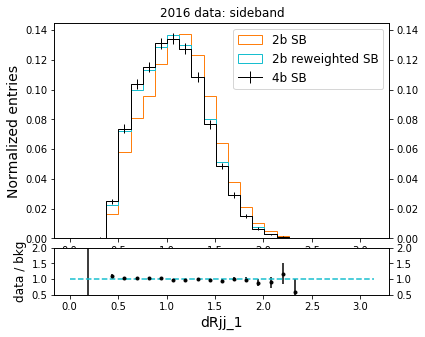

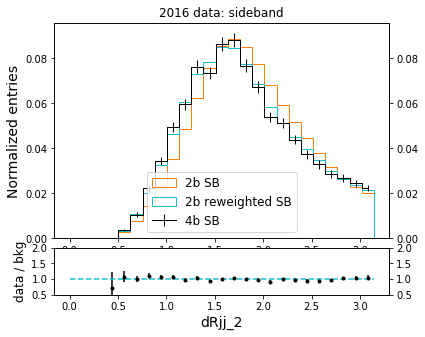

In [36]:
cf_1d_dists(data16_SB,nbi=25,figDir='figures/min_dRjj_h1/rw_2b/',
            tag='_SB_withOrig')

Note: I'm only showing Poissonian errors for the 4b data right now, so adding error bars for the 2b data and reweighted 2b data is something I could iterate on.

**Compare with the 1d distributions in the CR and SR**

This was something that Max said I could look at, so I agree, it's *worthwhile.*

In [ ]:
'''
Need to add a *mask* to this function, a
'''

# cf_1d_dists(data16_SB,nbi=25,figDir='figures/min_dRjj_h1/rw_2b/',
#             tag='_withOrig')

Also look at the 2b, 2b reweighted and 4b massplanes.

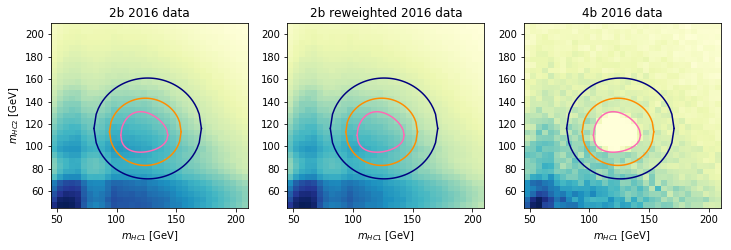

In [36]:
bkg_2b_rw_massplanes(data16,figDir="figures/min_dRjj_h1/")

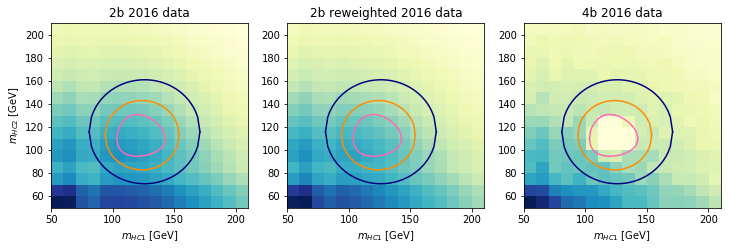

In [38]:
bkg_2b_rw_massplanes(data16,cb,mhi,figDir="figures/min_dRjj_h1/",tag="bkgRwt_coarserBins")

## Step 4: Quick cut based estimate of the sensitivity

### Compare the $m_{4j}$ in the SR


Note: I think I still need the overall normalization, because the 2b -> 4b reweighting was derived with normalized histograms.

In [ ]:
N

In [ ]:
smnr_mask = (smnr_SR.ntag >= 4)
data16_mask = (data16_SR.ntag == 2)

kargs = {'bins':25, 'range':(0,2000), 'histtype':'step', 'log':True}

sig,edg,_ = plt.hist(smnr_SR.loc[smnr_mask,'m_hh'],label='4b smnr',color='C4',
                     weights=smnr_SR.loc[smnr_mask,'mc_sf'],**kargs)

bkg,edg,_ = plt.hist(data16_SR.loc[data16_mask,'m_hh'],label='2b reweighted 2016 data',color='C9',
                     weights=N*data16_SR.loc[data16_mask,'w_2b'],**kargs)

ylim = plt.ylim()
plt.plot([400]*2,ylim,'grey',linestyle='--')
plt.ylim(ylim)

plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
plt.ylabel('Entries',fontsize=14)
plt.legend()
plt.title('SR: no kinematic constraint')

plt.savefig('figures/min_dRjj_h1/m_hh.pdf',bbox_inches='tight')

plt.show()

In [ ]:
edg

In [ ]:
sig

In [ ]:
edg[5]

In [ ]:
print('s/b: {}'.format(np.sum(sig)/np.sum(bkg)))
print('s/sqrt(b): {}'.format(np.sum(sig)/np.sqrt(np.sum(bkg))))

minBin = 4
print('s/b, mhh > 400 GeV: {}'.format(np.sum(sig[minBin:])/np.sum(bkg[minBin:])))
print('s/sqrt(b), mhh > 400 GeV: {}'.format(np.sum(sig[minBin:])/np.sqrt(np.sum(bkg[minBin:]))))

In [ ]:
.0763 / .0718

In [ ]:
np.sum(smnr_SR.loc[smnr_mask,'mc_sf'])

In [ ]:
m_min,m_max=400,1000

m_2b = data16_SR.loc[data16_mask,'m_hh']
w_2b = N * data16_SR.loc[data16_mask,'w_2b'] 

s = np.sum(smnr_SR.loc[smnr_mask & (smnr_SR.m_hh > m_min) & (smnr_SR.m_hh < m_max),'mc_sf'])
b = np.sum(w_2b[(m_2b > m_min) & (m_2b < m_max)])

print('Combined S/B {}'.format(s/b))
print('Combined S/sqrt(B) {}'.format(s/np.sqrt(b)))


Ok, this is like a 1% improvement... not a lot!

In [ ]:
m_mins = np.linspace(260,1250)
m_maxs = np.linspace(260,1250)

m_4b = smnr_SR.loc[smnr_mask,'m_hh']
w_4b = smnr_SR.loc[smnr_mask,'mc_sf']

m_2b = data16_SR.loc[data16_mask,'m_hh']
w_2b = N * data16_SR.loc[data16_mask,'w_2b']

s = np.array([[np.sum(w_4b[(m_4b > m_min) & (m_4b < m_max)]) for m_min in m_mins] for m_max in m_maxs[::-1]])
b = np.array([[np.sum(w_2b[(m_2b > m_min) & (m_2b < m_max)]) for m_min in m_mins] for m_max in m_maxs[::-1]]) 

# s / b
plt.figure()
plt.imshow(s/b,extent=[260,1250,260,1250])
plt.xlabel('min $(m_{4j})$')
plt.ylabel('max $(m_{4j})$')
plt.colorbar()
plt.title('$s/b$')

plt.savefig('figures/min_dRjj_h1/scan_s_b.pdf'.format(nv),bbox_inches='tight')


# s / sqrt(b)
plt.figure()
plt.imshow(s/np.sqrt(b),extent=[260,1250,260,1250])
plt.xlabel('min $(m_{4j})$')
plt.ylabel('max $(m_{4j})$')
plt.colorbar()
plt.title('$s/\sqrt{b}$')

plt.savefig('figures/min_dRjj_h1/scan_s_sqrtb.pdf'.format(nv),bbox_inches='tight')


### Maybe try adding in the kinematic constraint? 

Or perhaps this was more useful for the resonant analysis? I guess it's worth a shot.

In [ ]:
smnr_mask = (smnr_SR.ntag >= 4)
data16_mask = (data16_SR.ntag == 2)

kargs = {'bins':100, 'range':(250,1250), 'histtype':'step', 'log':True}

plt.hist(smnr_SR.loc[smnr_mask,'m_hh'],label='4b smnr',color='C4',
                     weights=smnr_SR.loc[smnr_mask,'mc_sf'],**kargs)

plt.hist(data16_SR.loc[data16_mask,'m_hh'],label='2b reweighted 2016 data',color='C9',
         weights=N * data16_SR.loc[data16_mask,'w_2b'], **kargs)

sig,edg,_ = plt.hist(smnr_SR.loc[smnr_mask,'m_hh_cor'],label='4b smnr: kinematic constraint',
                     color='C4',linestyle='--',
                     weights=smnr_SR.loc[smnr_mask,'mc_sf'],**kargs)

bkg,edg,_ = plt.hist(data16_SR.loc[data16_mask,'m_hh_cor'],label='2b reweighted 2016 data: kinematic constrain',
                     color='C9',linestyle='--',
                     weights=N * data16_SR.loc[data16_mask,'w_2b'], **kargs)

plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
plt.ylabel('Entries',fontsize=14)
plt.legend(bbox_to_anchor=(1,1.05))
plt.title('SR')

plt.savefig('figures/min_dRjj_h1/m_hh_cor.pdf',bbox_inches='tight')

plt.show()

I'm not sure if this helps as much for the non-resonant analysis or not?

I guess I could check by doing a limit comparison?

**$m_{hh}$ > 400 GeV**

In [ ]:
edg[15]

In [ ]:
minBin = 14

print("S / B",np.sum(sig[minBin:]) / np.sum(bkg[minBin:]))
print("S / sqrt(B)",np.sum(sig[minBin:]) / np.sqrt(np.sum(bkg[minBin:])))


The unscaled $m_{hh}$ distributions are giving better limits. 

## Step 5: Run the full statistical reweighting procedure

**Next step:** Feed these two histograms into the statscode framework, get workspace, and calculate the CLs. Ultimately, it would be nice to compare.

The stats code needs the signal and background histograms to be named
- sm_hh 
- qcd_hh

*I'm not sure what all the other options are for though...*

In [ ]:
from ROOT import TH1D
from root_numpy import fill_hist

In [ ]:
# Use the same edges that Patrick was using
# https://gitlab.cern.ch/hh4b/XhhResolved/blob/master/Root/hh4bHists.cxx#L42
edges = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
                  537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
                  1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076],dtype='float64')
ni = edges.shape[0] - 1

sm_hh  = TH1D("sm_hh", "sm_hh", ni,0,ni)
qcd_hh = TH1D("qcd_hh","qcd_hh",ni,0,ni)

sm_hh.Sumw2()
qcd_hh.Sumw2()

c = 'm_hh_cor'

fill_hist(sm_hh, np.digitize(smnr_SR.loc[smnr_mask,c],edges)-0.5, 
          weights=smnr_SR.loc[smnr_mask,'mc_sf'])
fill_hist(qcd_hh, np.digitize(data16_SR.loc[data16_mask,c],edges)-0.5, 
          weights=N * data16_SR.loc[data16_mask,'w_2b']) 

rfile_out = ROOT.TFile.Open('min_dRjj_h1_201.root', 'recreate')

sm_hh.Write()
qcd_hh.Write()

rfile_out.Close()


In [ ]:
sm_hh_unscaled  = TH1D("sm_hh", "sm_hh", ni,0,ni)
qcd_hh_unscaled = TH1D("qcd_hh","qcd_hh",ni,0,ni)

sm_hh_unscaled.Sumw2()
qcd_hh_unscaled.Sumw2()

c = 'm_hh'

fill_hist(sm_hh_unscaled, np.digitize(smnr_SR.loc[smnr_mask,c],edges)-0.5, 
          weights=smnr_SR.loc[smnr_mask,'mc_sf'])
fill_hist(qcd_hh_unscaled, np.digitize(data16_SR.loc[data16_mask,c],edges)-0.5, 
          weights=N * data16_SR.loc[data16_mask,'w_2b']) 

rfile_out = ROOT.TFile.Open('min_dRjj_h1_2016_unscaled.root', 'recreate')

sm_hh_unscaled.Write()
qcd_hh_unscaled.Write()

rfile_out.Close()

As a further sanity check, it might be nice to compare the kinematic constraint rescaling for the backgrounds as well, since I was a little bit concerned why I had such a different limit as Patrick.

In [ ]:
smnr_mask = (smnr_SR.ntag >= 4)
data16_mask = (data16_SR.ntag == 2)

kargs = {'bins':edges, 'histtype':'step', 'log':True}

plt.hist(smnr_SR.loc[smnr_mask,'m_hh'],label='4b smnr',color='C4',
                     weights=smnr_SR.loc[smnr_mask,'mc_sf'],**kargs)

plt.hist(data16_SR.loc[data16_mask,'m_hh'],label='2b reweighted 2016 data',color='C9',
         weights=N * data16_SR.loc[data16_mask,'w_2b'], **kargs)

sig,edg,_ = plt.hist(smnr_SR.loc[smnr_mask,'m_hh_cor'],label='4b smnr: kinematic constraint',
                     color='C4',linestyle='--',
                     weights=smnr_SR.loc[smnr_mask,'mc_sf'],**kargs)

bkg,edg,_ = plt.hist(data16_SR.loc[data16_mask,'m_hh_cor'],label='2b reweighted 2016 data: kinematic constraint',
                     color='C9',linestyle='--',
                     weights=N * data16_SR.loc[data16_mask,'w_2b'], **kargs)

plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
plt.ylabel('Entries',fontsize=14)
plt.legend(bbox_to_anchor=(1,1.05))
plt.title('SR')

plt.savefig('figures/min_dRjj_h1/m_hh_cor_PatrickBins.pdf',bbox_inches='tight')

plt.show()

I could use the tables that I print out to try to make a Brazil plot??